In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [3]:
data = pd.read_csv('/content/tiles_n.csv')

Statistical description of the data

In [4]:
new_data = data.drop(columns=data.columns[0])
new_data.describe()


,VOL,AREA_F,APT_NUM,ST_NUM,KREIS,ZIPCODE,YOC,ROOFTILE
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.00000,213.000000,213.000000
mean,1574.107981,156.450704,4.469484,4.544601,7.657277,8039.99061,1936.323944,12.687606
std,757.863091,56.051978,2.864101,1.142709,3.076065,17.05789,18.895773,7.720968
min,74.000000,30.000000,1.000000,1.000000,2.000000,8002.00000,1858.000000,0.000000
25%,981.000000,115.000000,1.000000,4.000000,6.000000,8038.00000,1931.000000,7.040000
50%,1584.000000,166.000000,5.000000,5.000000,9.000000,8048.00000,1940.000000,12.010000
75%,2006.000000,183.000000,6.000000,5.000000,10.000000,8050.00000,1950.000000,15.410000
max,3800.000000,406.000000,13.000000,7.000000,12.000000,8057.00000,1972.000000,34.610000


One-hot encode of categorical data


In [5]:
new_data['KREIS'] = new_data['KREIS'].astype('category')
new_data['ZIPCODE'] = new_data['ZIPCODE'].astype('category')
# One-hot encode the data using pandas get_dummies
new_data = pd.get_dummies(new_data)
print
print(new_data.columns)
print(new_data.shape)

Index(['VOL', 'AREA_F', 'APT_NUM', 'ST_NUM', 'YOC', 'ROOFTILE', 'KREIS_2',
       'KREIS_3', 'KREIS_4', 'KREIS_6', 'KREIS_7', 'KREIS_8', 'KREIS_9',
       'KREIS_10', 'KREIS_11', 'KREIS_12', 'ZIPCODE_8002', 'ZIPCODE_8003',
       'ZIPCODE_8004', 'ZIPCODE_8006', 'ZIPCODE_8008', 'ZIPCODE_8032',
       'ZIPCODE_8037', 'ZIPCODE_8038', 'ZIPCODE_8044', 'ZIPCODE_8045',
       'ZIPCODE_8046', 'ZIPCODE_8047', 'ZIPCODE_8048', 'ZIPCODE_8049',
       'ZIPCODE_8050', 'ZIPCODE_8051', 'ZIPCODE_8052', 'ZIPCODE_8053',
       'ZIPCODE_8055', 'ZIPCODE_8057', 'ROOF_F', 'ROOF_M', 'ROOF_O', 'ROOF_P',
       'POC_1900 - 1919', 'POC_1919 - 1945', 'POC_1946 - 1960',
       'POC_1961 - 1970', 'POC_1971 - 1980', 'POC_< 1919'],
      dtype='object')
(213, 46)


In [6]:
pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Split data into TEST (T) that I don't touch and train + validation set (TV)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# labels as numpy array
Y=np.array(new_data['ROOFTILE'])

#features as numpy array
X_list= new_data.drop(columns='ROOFTILE')
X = np.array(X_list)

#save headers for later
headers = list(X_list.columns)

X_TV, X_T, Y_TV, Y_T = train_test_split(X,Y,test_size = 0.15, random_state = 296) #this split, meaning, this random seed, has to be the same for all the models!

print(X_T, Y_T)

[[3130  182   10 ...    0    0    0]
 [2490  168    8 ...    0    0    0]
 [1942  174    6 ...    0    0    0]
 ...
 [1945  174    6 ...    0    0    0]
 [1350  144    6 ...    0    0    0]
 [1529  166    5 ...    0    0    0]] [15.54 12.36 15.99 12.33  7.84 13.9   6.71 10.32  2.93 23.78 23.18 15.09
 19.05 13.39  0.   13.6  12.1  12.79  3.89 13.01 12.54  5.   25.5  23.18
  7.99 15.66  8.1   6.87 15.04  6.71 12.38  9.4 ]


Hyperparameter search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

model_pipe = xgb.XGBRegressor(objective='reg:squarederror')

#Metrics for Evualation:
met_grid= ['r2', 'neg_mean_absolute_error'] #The metric codes from sklearn

# Create the parameter grid based on the results of random search 
params = {
          'max_depth': [12],
        'min_child_weight': [1],
        'gamma': [25,27,30,32,35],
        'learning_rate': [0.2],
        'subsample': [0.85],
        'colsample_bylevel': [0.6],
        'colsample_bytree': [0.3],
        'n_estimators': [400],
        'lambda' : [10]
      }

# Instantiate the grid search model
grid_search = RandomizedSearchCV(model_pipe, param_distributions = params, scoring = met_grid, refit = 'r2', n_iter = 100,
                                cv = 5, n_jobs = 1, verbose = 10, return_train_score = True)
# Fit the grid search to the data
grid_search.fit(X_TV, Y_TV)

from google.colab import files

gd_w = pd.DataFrame(grid_search.cv_results_)
gd_w.to_csv('grid_search_z_xgb.csv', encoding = 'utf-8-sig') 
files.download('grid_search_z_xgb.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 5 is smaller than n_iter=100. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START colsample_bylevel=0.6, colsample_bytree=0.3, gamma=25, lambda=10, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=400, subsample=0.85
[CV 1/5; 1/5] END colsample_bylevel=0.6, colsample_bytree=0.3, gamma=25, lambda=10, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=400, subsample=0.85; neg_mean_absolute_error: (train=-1.231, test=-4.394) r2: (train=0.960, test=0.367) total time=   0.1s
[CV 2/5; 1/5] START colsample_bylevel=0.6, colsample_bytree=0.3, gamma=25, lambda=10, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=400, subsample=0.85
[CV 2/5; 1/5] END colsample_bylevel=0.6, colsample_bytree=0.3, gamma=25, lambda=10, learning_rate=0.2, max_depth=12, min_child_weight=1, n_estimators=400, subsample=0.85; neg_mean_absolute_error: (train=-1.230, test=-5.790) r2: (train=0.959, test=0.052) total time=   0.1s
[CV 3/5; 1/5] START colsample_bylevel=0.6, colsamp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

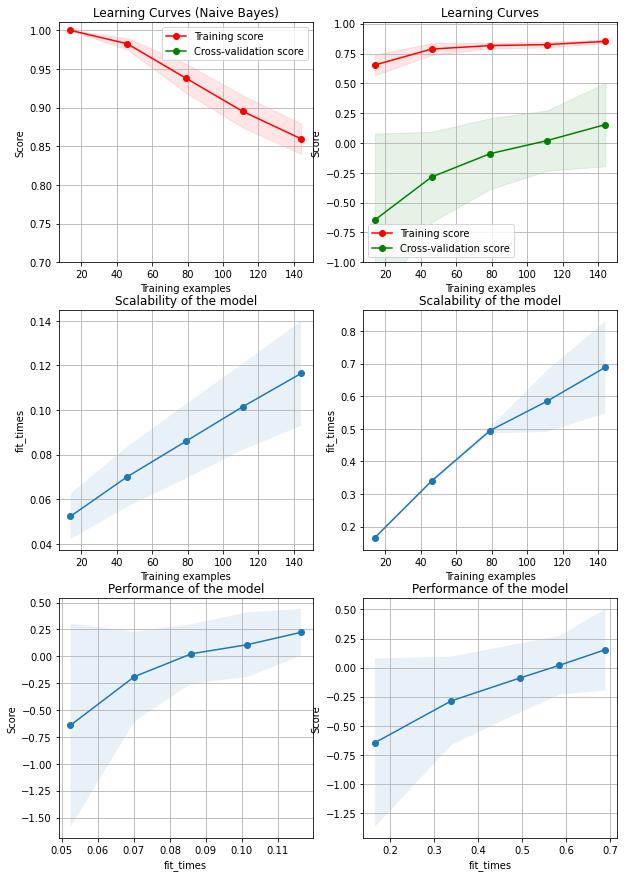

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = X_TV, Y_TV

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = xgb.XGBRegressor(objective='reg:squarederror')
plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=axes[:, 0],
    ylim=(0.7, 1.01),
    cv=cv,
    n_jobs=4,
    scoring="r2",
)

title = r"Learning Curves"

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = xgb.XGBRegressor(objective='reg:squarederror', 
          max_depth=12,
          gamma = 100,
        min_child_weight=0.3,
        learning_rate=0.2,
      subsample=0.8,
        colsample_bylevel = 0.85,
        colsample_bytree=0.3,
        n_estimators= 600)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(-1, 1.01), cv=cv, n_jobs=4
)

plt.show()

Apply chosen hyperparams

In [8]:
cv_results_ = pd.read_csv('/content/grid_search_z_xgb.csv')

Test on a Validation set

In [ ]:
### THIS IS NOT NECESSARY, JUST A SANITY CHECK WHICH CONFIRMS THE NUMBERS FROM THE .csv ############

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from statistics import mean

# Create the parameter grid based on the results of random search

chosen_index = 2 #grid_search_z_xgb.csv

print(cv_results_['params'][chosen_index])
tv_rf = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators = cv_results_['param_n_estimators'][chosen_index],
    max_depth = cv_results_['param_max_depth'][chosen_index],
    min_child_weight = cv_results_['param_min_child_weight'][chosen_index],
    gamma = cv_results_['param_gamma'][chosen_index],
    learning_rate = cv_results_['param_learning_rate'][chosen_index],
    subsample = cv_results_['param_subsample'][chosen_index],
    colsample_bylevel = cv_results_['param_colsample_bylevel'][chosen_index],
    colsample_bytree = cv_results_['param_colsample_bytree'][chosen_index]
)

# evaluate the model
cv = StratifiedKFold(n_splits=10, shuffle = True, random_state=42)
mae_v = cross_val_score(tv_rf, X_TV, Y_TV, scoring='neg_mean_absolute_error', cv=5, n_jobs=1)

# report performance
print('MAE:', (mean(mae_v)*(-1), "Standard deviation: ", np.std(mae_v)))

r2_v = cross_val_score(tv_rf, X_TV, Y_TV, scoring='r2', cv=5, n_jobs=1)
print('R2', (mean(r2_v), "Standard deviation: ", np.std(r2_v)))


{'subsample': 0.85, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.2, 'lambda': 10, 'gamma': 30, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.6}
MAE: (4.512539594821385, 'Standard deviation: ', 0.9052781902054884)
R2 (0.2933908055332767, 'Standard deviation: ', 0.12687026627270853)


Read Train + Validation results

Validation r2 score:  0.29 
 Standard deviation:  0.13
Train r2 score:  0.95 
 Standard deviation:  0.01
Validation MAE score:  -4.51 
 Standard deviation:  0.91
Train MAE score:  -1.4 
 Standard deviation:  0.03


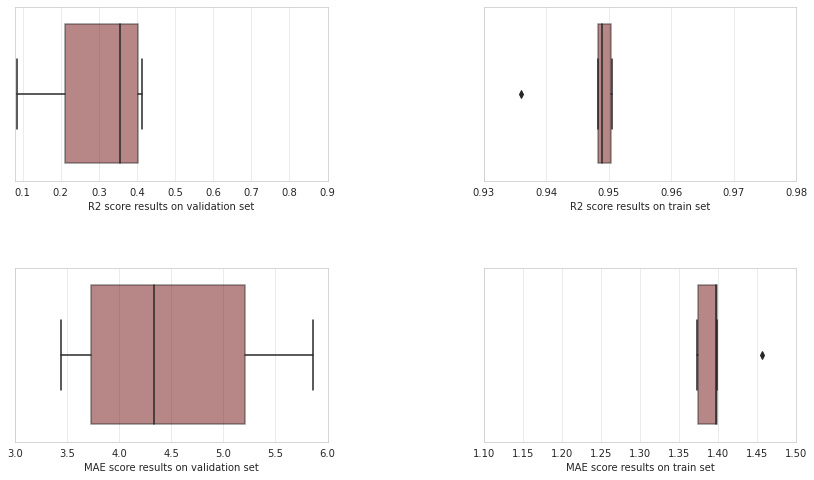

In [13]:
chosen_index = 2 #grid_search_z_xgb.csv

r2_v = []
mae_v = []
r2_tr = []
mae_tr = []

for i in range (5):
  v_r2 = "split"+str(i)+"_test_r2"  
  v_mae = "split"+str(i)+"_test_neg_mean_absolute_error"
  r2_v.append(cv_results_[v_r2][chosen_index])
  mae_v.append(cv_results_[v_mae][chosen_index]*(-1))

  tr_r2 = "split"+str(i)+"_train_r2"  
  tr_mae = "split"+str(i)+"_train_neg_mean_absolute_error"
  r2_tr.append(cv_results_[tr_r2][chosen_index])
  mae_tr.append(cv_results_[tr_mae][chosen_index]*(-1))

print("Validation r2 score: ", round(cv_results_['mean_test_r2'][chosen_index],2), "\n Standard deviation: ", round(cv_results_['std_test_r2'][chosen_index],2) )
print("Train r2 score: ", round(cv_results_['mean_train_r2'][chosen_index],2),"\n Standard deviation: ", round(cv_results_['std_train_r2'][chosen_index],2))
print("Validation MAE score: ", round(cv_results_['mean_test_neg_mean_absolute_error'][chosen_index],2), "\n Standard deviation: ", round(cv_results_['std_test_neg_mean_absolute_error'][chosen_index],2) )
print("Train MAE score: ", round(cv_results_['mean_train_neg_mean_absolute_error'][chosen_index],2),"\n Standard deviation: ", round(cv_results_['std_train_neg_mean_absolute_error'][chosen_index],2))
metrics_TV = pd.DataFrame(list(zip(r2_v,mae_v,r2_tr,mae_tr)), columns =['r2_validation', 'MAE_validation', 'r2_train', 'MAE_train',])

spacing = 0.5
f = plt.figure(figsize=(14,8))
gs = f.add_gridspec(2, 2)
gs.update(wspace = spacing, hspace = spacing)


with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[0, 0])
    sns.boxplot(data=metrics_TV, x="r2_validation", color = "maroon", boxprops=dict(alpha=.5)).set(
    xlabel='R2 score results on validation set')
    plt.xlim(0.08,0.9)

with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[0, 1])
    sns.boxplot(data=metrics_TV, x="r2_train", color = "maroon", boxprops=dict(alpha=.5)).set(
    xlabel='R2 score results on train set')
    plt.xlim(0.93,0.98)

with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[1, 0])
    sns.boxplot(data=metrics_TV, x="MAE_validation", color = "maroon", boxprops=dict(alpha=.5)).set(
    xlabel='MAE score results on validation set')
    plt.xlim(3,6)


with sns.axes_style("whitegrid", {"grid.color": ".9"}):
    ax = f.add_subplot(gs[1, 1])
    sns.boxplot(data=metrics_TV, x="MAE_train", color = "maroon", boxprops=dict(alpha=.5)).set(
    xlabel='MAE score results on train set')
    plt.xlim(1.1,1.5)
f.savefig('zieg_xb.png')


Hyperparameters applied to (T) set


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

r2=[]
MAE=[]

t_rf = xgb.XGBRegressor(
    
    objective='reg:squarederror',
    n_estimators = cv_results_['param_n_estimators'][chosen_index],
    max_depth = cv_results_['param_max_depth'][chosen_index],
    min_child_weight = cv_results_['param_min_child_weight'][chosen_index],
    gamma = cv_results_['param_gamma'][chosen_index],
    learning_rate = cv_results_['param_learning_rate'][chosen_index],
    subsample = cv_results_['param_subsample'][chosen_index],
    colsample_bylevel = cv_results_['param_colsample_bylevel'][chosen_index],
    colsample_bytree = cv_results_['param_colsample_bytree'][chosen_index]
)


t_rf.fit(X_TV, Y_TV)

# Get Y predicted
predictions=t_rf.predict(X_T)

# Print out the mean absolute error (mae)
MAE = round(mean_absolute_error(Y_T, predictions),2)
print('Mean Absolute Error:', MAE)

# Print out R2
print('R2:', round(r2_score(Y_T, predictions),2))

Mean Absolute Error: 3.99
R2: 0.01


Fitted vs Actual plot (Test set)

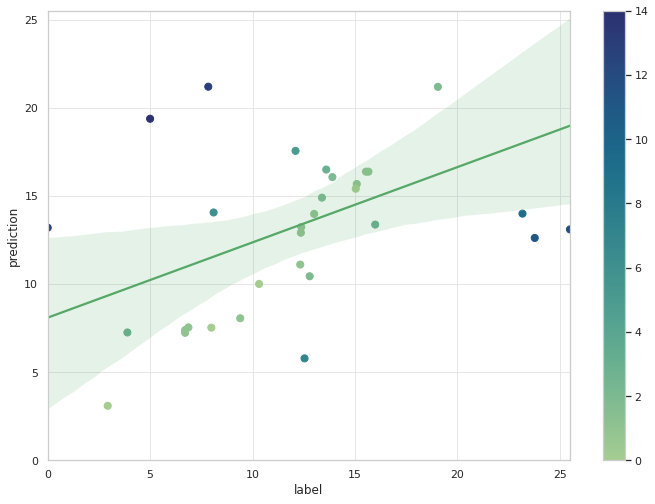

In [ ]:
# Visualising  results
limit = max(Y_T)
predictions = t_rf.predict(X_T)
mae = np.round(abs(Y_T - predictions))
d = {'label': Y_T, 'prediction': predictions, 'mae': mae}
plot = pd.DataFrame(data = d)
# plot absolute settings
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid", {"grid.color": ".9"})

points = plt.scatter(d["label"], d["prediction"], s=50, c=d["mae"], cmap="crest")
plt.colorbar(points)
plt.xlim(0, limit)
plt.ylim(0, limit)

sns.regplot(
    x="label", y="prediction", data=plot, scatter = False, color='g')
 

Absolute error in the test set plot

<AxesSubplot:xlabel='dataset', ylabel='Absolute error'>

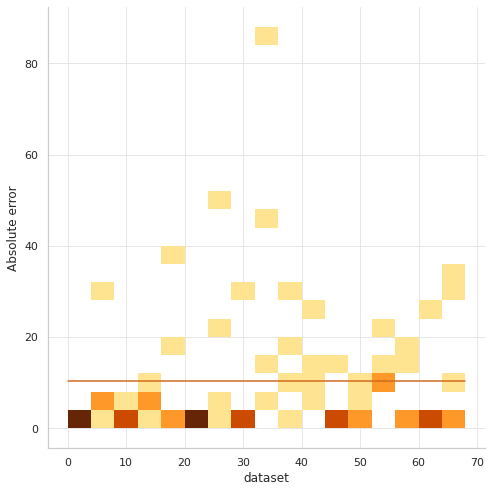

In [ ]:
# Visualising the Random Forest Regression results
n = 69 #number of data points


sns.set_style("whitegrid", {"grid.color": ".9"})
numbers = np.array(list(range(0,int(n),+1)))

value = np.round(abs(Y_test - predictions))
d = {'Absolute error': value, 'dataset': numbers}
plot = pd.DataFrame(data = d)

sns.displot(data = plot, x="dataset", y="Absolute error", height=7,
    aspect=1, binwidth=(4, 4), cmap="YlOrBr")

sns.lineplot(data = plot, x="dataset", y=MAE, color = 'chocolate')

Feature importance

In [ ]:
from scipy.special import softmax
from sklearn.feature_selection import SelectFwe, chi2

def print_feature_importances_random_forest(random_forest_model):
    
    '''
    Prints the feature importances of a Random Forest model in an ordered way.
    random_forest_model -> The sklearn.ensemble.RandomForestRegressor or RandomForestClassifier trained model
    '''
    
    # Fetch the feature importances and feature names
    importances = rf.feature_importances_
    features = h_X
    
    # Organize them in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

def print_feature_importances_shap_values(shap_values, features):
    
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''

    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)

    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}

    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [ ]:
# Prints the feature importances
print_feature_importances_random_forest(rf)

AREA_F -> 0.2171
VOL -> 0.1756
YOC -> 0.1063
APT_NUM -> 0.0727
ZIPCODE_8052 -> 0.0429
ZIPCODE_8057 -> 0.0307
ST_NUM -> 0.0284
KREIS_6 -> 0.0245
ZIPCODE_8044 -> 0.0245
ZIPCODE_8049 -> 0.0235
KREIS_9 -> 0.0197
ZIPCODE_8006 -> 0.0184
ROOF_O -> 0.0182
ZIPCODE_8053 -> 0.0169
KREIS_11 -> 0.0165
ZIPCODE_8048 -> 0.0162
POC_8013 -> 0.0134
KREIS_10 -> 0.0125
ZIPCODE_8051 -> 0.0125
ZIPCODE_8032 -> 0.0119
ROOF_M -> 0.0108
KREIS_7 -> 0.0107
KREIS_12 -> 0.0100
ZIPCODE_8055 -> 0.0095
POC_8012 -> 0.0083
POC_8011c -> 0.0082
ROOF_P -> 0.0068
ZIPCODE_8002 -> 0.0060
KREIS_2 -> 0.0044
ZIPCODE_8050 -> 0.0034
POC_8014 -> 0.0034
ZIPCODE_8004 -> 0.0023
KREIS_4 -> 0.0022
POC_8011d -> 0.0022
ZIPCODE_8047 -> 0.0020
ROOF_F -> 0.0018
KREIS_3 -> 0.0016
ZIPCODE_8046 -> 0.0014
ZIPCODE_8038 -> 0.0008
ZIPCODE_8003 -> 0.0005
ZIPCODE_8005 -> 0.0004
KREIS_5 -> 0.0004
ZIPCODE_8045 -> 0.0002
POC_8015 -> 0.0002
ZIPCODE_8037 -> 0.0002
ZIPCODE_8008 -> 0.0001
KREIS_8 -> 0.0001
POC_8011b -> 0.0000


In [15]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 6.6 MB/s 


In [16]:
import shap
# Fits the explainer
explainer = shap.Explainer(t_rf, feature_names = headers)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X)

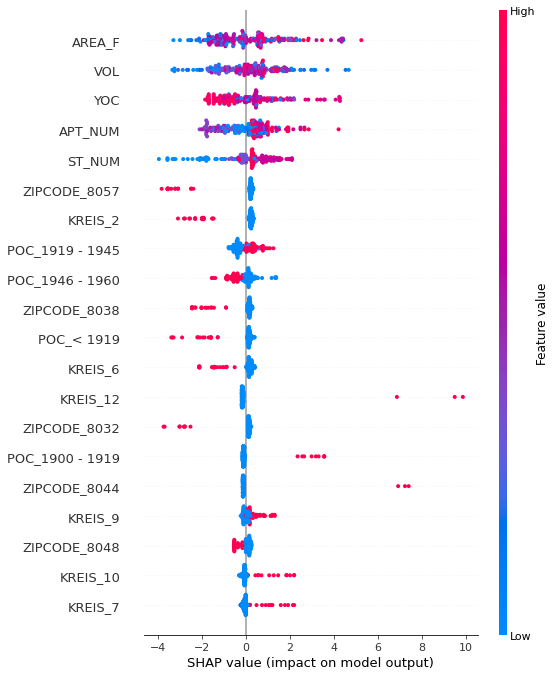

In [17]:
shap.summary_plot(shap_values)